# Step 1 : Importing Necessary Library
Pada step ini kami melakukan import library-library yang akan digunakan selama mengerjakan competition ini

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from PIL import Image
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16

# Step 2 : Data Preparation

Pertama-tama kami mendeklarasi path file menuju dataset yang terdapat pada competition dan meng-assign masing-masing file mulai dari train_csv, file test, dan file train

In [23]:
path = '/kaggle/input/penyisihan-hology-7-data-mining-competition/'

In [24]:
classpath = os.listdir(path)
classpath

['sample_submission.csv', 'train.csv', 'test', 'train']

In [25]:
train_csv_path = os.path.join(path, 'train.csv')
test_path = os.path.join(path, 'test/test')
train_path = os.path.join(path, 'train/train')

In [26]:
df = pd.read_csv(train_csv_path)
df.head()

,id,jenis,warna
0,1,1,1
1,2,0,2
2,3,1,3
3,4,1,1
4,5,0,4


 ## Menentukan Path Gambar Berdasarkan Format File

Pada tahap ini, kami membuat fungsi untuk memeriksa ketersediaan file gambar dalam format .jpg atau .png dan mengembalikan path yang sesuai untuk setiap gambar.

* **Fungsi get_image_path**: Fungsi ini menerima image_id (ID unik untuk setiap gambar) dan train_path (path direktori tempat gambar berada). Fungsi ini memeriksa keberadaan file gambar dalam dua format:
    1. ".jpg": Jika file dengan format .jpg ditemukan, fungsi akan mengembalikan path gambar tersebut.
    2. ".png": Jika file .jpg tidak tersedia, fungsi akan memeriksa file .png. Jika ditemukan, fungsi mengembalikan path gambar .png.
    3. Jika tidak ada file yang ditemukan, fungsi akan mengembalikan None.


* **Penerapan ke DataFrame**: Fungsi ini diterapkan pada setiap id gambar di DataFrame df untuk menetapkan kolom image_path, yang berisi path gambar yang telah terverifikasi keberadaannya.

In [27]:
# Function to check if the image is available as .jpg or .png
def get_image_path(image_id, train_path):
    # Check for .jpg version first
    jpg_path = os.path.join(train_path, f'{image_id}.jpg')
    if os.path.exists(jpg_path):
        return jpg_path
    # If not found, check for .png version
    png_path = os.path.join(train_path, f'{image_id}.png')
    if os.path.exists(png_path):
        return png_path
    # If neither exists, return None or raise an error
    return None

# Apply this function to assign the correct image path
df['image_path'] = df['id'].apply(lambda x: get_image_path(x, train_path))

# Inspect the DataFrame to ensure paths are correctly assigned
print(df.head())

   id  jenis  warna                                         image_path
0   1      1      1  /kaggle/input/penyisihan-hology-7-data-mining-...
1   2      0      2  /kaggle/input/penyisihan-hology-7-data-mining-...
2   3      1      3  /kaggle/input/penyisihan-hology-7-data-mining-...
3   4      1      1  /kaggle/input/penyisihan-hology-7-data-mining-...
4   5      0      4  /kaggle/input/penyisihan-hology-7-data-mining-...


# Step 2 : Memuat dan Pre-prosessing Gambar
Pada bagian ini, kami mengembangkan fungsi untuk memuat dan memproses gambar dari dua format yang berbeda, yaitu .png dan .jpg. Fungsi ini juga melakukan normalisasi pada gambar untuk memastikan konsistensi pada input data model.

* **Fungsi load_image**: Fungsi ini menerima image_path (path dari gambar) dan img_size (ukuran gambar yang diinginkan) sebagai parameter. Alur kerjanya adalah sebagai berikut:

    1. Jika gambar berformat .png:
        Memuat gambar menggunakan library Pillow.
        Mengubah gambar menjadi mode RGB.
        Mengonversi gambar ke array NumPy dan kemudian menjadi tensor TensorFlow.
        Me-resize gambar ke ukuran yang telah ditentukan (img_size).

    2. Jika gambar berformat .jpg, gambar diproses langsung menggunakan TensorFlow:
        Gambar dibaca menggunakan tf.io.read_file.
        Decoding dilakukan melalui tf.image.decode_jpeg dengan menetapkan channels=3.
        Gambar kemudian diresize ke ukuran img_size.
    3. Seluruh gambar dinormalisasi ke rentang [0, 1].
    
    
* **Penerapan ke DataFrame**: Fungsi ini diterapkan pada setiap path gambar di DataFrame df untuk menetapkan kolom baru, image_tensor, yang berisi tensor gambar yang telah diproses.

In [28]:
# Function to load and preprocess images
def load_image(image_path, img_size=(224, 224)):
    if image_path.endswith('.png'):
        # Open the PNG image using Pillow
        img = Image.open(image_path)
        img = img.convert('RGB')  # Convert to RGB
        img = np.array(img)  # Convert to a NumPy array
        image = tf.convert_to_tensor(img, dtype=tf.float32)  # Convert to Tensor
        image = tf.image.resize(image, img_size)  # Resize
    else:
        # Process JPEG images directly with TensorFlow
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)

    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image

# Apply the image processing function to each image path
df['image_tensor'] = df['image_path'].apply(load_image)

# Inspect the DataFrame to check the image tensors
df.head()

,id,jenis,warna,image_path,image_tensor
0,1,1,1,/kaggle/input/penyisihan-hology-7-data-mining-...,"(((tf.Tensor(0.9490196, shape=(), dtype=float3..."
1,2,0,2,/kaggle/input/penyisihan-hology-7-data-mining-...,"(((tf.Tensor(1.0, shape=(), dtype=float32), tf..."
2,3,1,3,/kaggle/input/penyisihan-hology-7-data-mining-...,"(((tf.Tensor(0.2901961, shape=(), dtype=float3..."
3,4,1,1,/kaggle/input/penyisihan-hology-7-data-mining-...,"(((tf.Tensor(0.90588236, shape=(), dtype=float..."
4,5,0,4,/kaggle/input/penyisihan-hology-7-data-mining-...,"(((tf.Tensor(0.40784314, shape=(), dtype=float..."


In [29]:
print('Distribusi data pada label jenis')
print(df['jenis'].value_counts())
print('Distribusi data pada label warna')
print(df['warna'].value_counts())

Distribusi data pada label jenis
jenis
0    476
1    301
Name: count, dtype: int64
Distribusi data pada label warna
warna
3    234
2    162
4    140
1    125
0    116
Name: count, dtype: int64


## Menyeimbangkan Dataset Gambar Menggunakan SMOTE

Pada bagian ini, kami melakukan proses untuk mengatasi ketidakseimbangan data (inbalance) pada dataset dengan menerapkan SMOTE (Synthetic Minority Over-sampling Technique) pada gambar yang telah diproses. Proses ini terdiri dari beberapa langkah:

* **Mengatur Bentuk Asli Gambar**: Kami mendefinisikan bentuk asli gambar sebagai (224, 224, 3), yang merupakan ukuran gambar setelah preprocessing.

* **Fungsi flatten_image_tensors**: Fungsi ini digunakan untuk mengubah tensor gambar menjadi vektor satu dimensi. Setiap tensor gambar diflatten agar sesuai dengan persyaratan input dari SMOTE.

* **Fitur dan Label**:

    * X: Berisi fitur dari gambar yang telah diflatten menggunakan fungsi flatten_image_tensors.
    * y: Berisi label atau kelas (jenis) yang akan diseimbangkan.

* **Mengaplikasikan SMOTE**: Menggunakan SMOTE untuk menyeimbangkan jumlah sampel pada setiap kelas, dengan mengatur random_state=42 agar proses replikasi dapat diulang.

* **Reshape dan Konversi Kembali ke Tensor**:
    * Setelah resampling, gambar diformat ulang ke bentuk aslinya (224, 224, 3).
    * Kemudian dikonversi kembali menjadi tensor menggunakan tf.convert_to_tensor untuk memastikan kompatibilitas dengan pipeline pemrosesan.

* **Menyimpan Dataset yang Telah Disampling Ulang**:
    * Dataset baru yang telah diseimbangkan disimpan dalam DataFrame baru resampled_df dan resampled_df2, dengan kolom image_tensor berisi gambar yang telah diproses dan kolom jenis sebagai labelnya.
    * Distribusi kelas yang telah diseimbangkan kemudian diperiksa untuk memastikan kesetaraan jumlah sampel pada setiap kelas.

In [30]:
# Define image shape
original_shape = (224, 224, 3)

# Function to flatten image tensors
def flatten_image_tensors(image_tensors):
    return np.array([img.numpy().flatten() for img in image_tensors])  # Ensure tensors are converted to numpy

# Features and labels
X = flatten_image_tensors(df['image_tensor'].values)  # Flatten images
y = df['jenis'].values  # Labels

# Initialize SMOTE
smot = SMOTE(random_state=42)

# Resample the training dataset
X_resampled, y_resampled = smot.fit_resample(X, y)

# Reshape and convert back to tensors
# Calculate the number of samples
num_samples = X_resampled.shape[0]

# Reshape back to original dimensions
reshaped_images = X_resampled.reshape(num_samples, *original_shape)

# Convert to TensorFlow tensors
image_tensors = tf.convert_to_tensor(reshaped_images, dtype=tf.float32)  
print(image_tensors.shape) 

# Create a new DataFrame for resampled data
resampled_df = pd.DataFrame({
    'image_tensor': list(image_tensors.numpy()),  # Convert tensor to numpy for DataFrame
    'jenis': y_resampled
})

# Check the distribution of the resampled dataset
print(resampled_df['jenis'].value_counts())

(952, 224, 224, 3)
jenis
1    476
0    476
Name: count, dtype: int64


In [31]:
# Define image shape
original_shape = (224, 224, 3) 

# Function to flatten image tensors
def flatten_image_tensors(image_tensors):
    return np.array([img.numpy().flatten() for img in image_tensors])

# Features and labels
X = flatten_image_tensors(df['image_tensor'].values)  # Flatten images
y = df['warna'].values  # Labels

# Initialize SMOTE
smot = SMOTE(random_state=42)

# Resample the training dataset
X_resampled, y_resampled = smot.fit_resample(X, y)

# Reshape and convert back to tensors
# Calculate the number of samples
num_samples = X_resampled.shape[0]

# Reshape back to original dimensions
reshaped_images = X_resampled.reshape(num_samples, *original_shape)

# Convert to TensorFlow tensors
image_tensors = tf.convert_to_tensor(reshaped_images, dtype=tf.float32)  # Make sure dtype matches your model's expectations
print(image_tensors.shape)  

# Create a new DataFrame for resampled data
resampled_df2 = pd.DataFrame({
    'image_tensor': list(image_tensors.numpy()),  # Convert tensor to numpy for DataFrame
    'warna': y_resampled
})

# Check the distribution of the resampled dataset
print(resampled_df2['warna'].value_counts())

(1170, 224, 224, 3)
warna
1    234
2    234
3    234
4    234
0    234
Name: count, dtype: int64


# Step 3: Modelling

## Mengatur Callback untuk Menyimpan Model Terbaik dan Mengurangi Learning Rate

Untuk memastikan model yang dilatih dapat mencapai performa optimal, kami menggunakan dua jenis callback dari Keras:

* **ModelCheckpoint**: Callback ini digunakan untuk menyimpan model terbaik selama proses pelatihan berdasarkan nilai validasi loss. Terdapat dua instance ModelCheckpoint, masing-masing untuk model klasifikasi jenis (tipe baju) dan warna (warna baju):
    * checkpoint_path_color: Menyimpan model terbaik berdasarkan validasi loss untuk klasifikasi warna baju (color).
    * checkpoint_path_type: Menyimpan model terbaik berdasarkan validasi loss untuk klasifikasi tipe baju (type).
    * Parameter utama:
        * monitor='val_loss': Callback akan memantau nilai val_loss untuk menentukan kapan model terbaik ditemukan.
        * save_best_only=True: Hanya menyimpan model terbaik (yang memiliki val_loss terendah).
        * mode='min': Mode ini bertujuan untuk meminimalkan nilai val_loss.
* **ReduceLROnPlateau**: Callback ini digunakan untuk mengurangi learning rate secara otomatis jika tidak ada peningkatan performa pada val_loss dalam beberapa epoch tertentu.
    * Parameter utama:
        * monitor='val_loss': Memantau val_loss untuk menentukan kapan learning rate perlu dikurangi.
        * factor=0.5: Mengurangi learning rate menjadi 50% dari nilai sebelumnya.
        * patience=3: Jika tidak ada peningkatan dalam 3 epoch berturut-turut, learning rate akan dikurangi.
        * min_lr=1e-6: Menetapkan batas bawah pada learning rate.

In [32]:
checkpoint_path_color = 'best_color_model.keras'  # Path to save the best model
model_checkpoint_color = ModelCheckpoint(
    checkpoint_path_color,               # File path to save the model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only the best model
    mode='min',                    # Minimize validation loss
    verbose=1,                     # Verbosity mode
)
checkpoint_path_type = 'best_type_model.keras'  # Path to save the best model
model_checkpoint_type = ModelCheckpoint(
    checkpoint_path_type,               # File path to save the model
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only the best model
    mode='min',                    # Minimize validation loss
    verbose=1,                     # Verbosity mode
)
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Watch the validation loss
    factor=0.5,             # Factor by which to reduce the learning rate
    patience=3,             # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6             # Lower bound on the learning rate
)

## Membangun Model CNN untuk Klasifikasi Warna Pakaian
Pada bagian ini, kami mendefinisikan arsitektur model Convolutional Neural Network (CNN) yang digunakan untuk klasifikasi warna. Model ini terdiri dari beberapa blok konvolusi, pengurangan dimensi, dan lapisan koneksi penuh. Bagian ini dikususkan untuk mendeteksi warna pada kaos atau hoodie agar kami mendapatkan model yang lebih akurat.

In [33]:
# Define a CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the output from the convolutional layers
    model.add(layers.Flatten())
    
    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification
    
    return model

# Example usage
input_shape = (224, 224, 3)  # Example input shape (height, width, channels)
num_classes = 5  # Number of color classes (red, yellow, blue, black, white)

model = create_cnn_model(input_shape, num_classes)
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## Melatih Model CNN
Pada bagian ini, kami melatih model CNN yang telah didefinisikan sebelumnya dengan menggunakan dataset yang telah diseimbangkan. Proses pelatihan melibatkan beberapa parameter dan callback yang telah disiapkan sebelumnya.

In [35]:
# Train the model
model.fit(
    np.array(resampled_df2['image_tensor'].tolist()), 
    {'color_output': resampled_df2['warna']},
    epochs=15,
    batch_size=32,
    validation_split=0.3,
    shuffle=True,
    callbacks=[model_checkpoint_color, reduce_lr]  
)

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5300 - loss: 1.2466
Epoch 1: val_loss improved from inf to 0.09726, saving model to best_color_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.5370 - loss: 1.2293 - val_accuracy: 0.9829 - val_loss: 0.0973 - learning_rate: 0.0010
Epoch 2/15
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9359 - loss: 0.2986
Epoch 2: val_loss improved from 0.09726 to 0.06272, saving model to best_color_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9370 - loss: 0.2929 - val_accuracy: 0.9829 - val_loss: 0.0627 - learning_rate: 0.0010
Epoch 3/15
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9712 - loss: 0.1194
Epoch 3: val_loss improved from 0.06272 to 0.04770, saving model to best_color_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9709 - loss: 0.1197 - val_accuracy: 0.9915 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 4/15
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - a

## Membangun Model CNN untuk Klasifikasi Baju
Pada bagian ini,  kami menggunakan arsitektur VGG16 yang telah dilatih sebelumnya sebagai dasar untuk model CNN kami dan akan digunakan untuk klasifikasi Baju. Model ini terdiri dari beberapa blok konvolusi, pengurangan dimensi, dan lapisan koneksi penuh. Bagian ini dikususkan untuk mendeteksi jenis pakaian yaitu; kaos atau hoodie agar kami mendapatkan model yang lebih akurat.

In [37]:
def create_cnn_with_vgg16(input_shape):
    # Load VGG16 model without the top layer and with pretrained weights
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model on top of the VGG16 base
    model = models.Sequential()
    model.add(base_model)  # Add VGG16 base model
    model.add(layers.Flatten())  # Flatten the output of the base model
    model.add(layers.Dense(128, activation='relu'))  # Fully connected layer
    model.add(layers.Dropout(0.5))  # Dropout layer for regularization
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    return model

# Example usage
input_shape = (224, 224, 3)  # Input shape for VGG16
model_type = create_cnn_with_vgg16(input_shape)

# Compile the model
model_type.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model_type.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Melatih Model CNN Menggunakan VGG16
Pada bagian ini, kami akan melatih model CNN yang telah dibangun menggunakan arsitektur VGG16. Proses pelatihan ini melibatkan pengaturan data input, parameter pelatihan, dan penggunaan callback untuk meningkatkan performa model.

In [38]:
model_type.fit(
    np.array(resampled_df['image_tensor'].tolist()), 
    {'type_output': resampled_df['jenis']},
    epochs=15,
    batch_size=32,
    validation_split=0.3,
    shuffle=True,
    callbacks=[reduce_lr, model_checkpoint_type]  # Adding callbacks
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6666 - loss: 1.3281
Epoch 1: val_loss did not improve from 0.06417
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.6709 - loss: 1.3079 - val_accuracy: 0.8287 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9030 - loss: 0.2769
Epoch 2: val_loss did not improve from 0.06417
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9035 - loss: 0.2750 - val_accuracy: 0.9406 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9295 - loss: 0.1607
Epoch 3: val_loss did not improve from 0.06417
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.9302 - loss: 0.1598 - val_accuracy: 0.9545 - val_loss: 0.1198 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9739 - loss: 0.0922
Epoch 4: val_loss did not improve from 0.06417
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - ac

# Step 4: Prediction
## Memuat dan Memprediksi Gambar dengan Model
Pada bagian ini, kami akan memuat gambar dari direktori test, memproses gambar tersebut agar sesuai dengan input model, dan kemudian membuat prediksi menggunakan model CNN yang telah dilatih. Kami juga akan memvisualisasikan hasil prediksi.

* **Fungsi preprocess_image**:
    Fungsi ini digunakan untuk memuat dan memproses gambar tunggal agar sesuai dengan bentuk input model. Berikut adalah langkah-langkah yang dilakukan:

    * Memuat dan Mengubah Ukuran Gambar: 
        image.load_img(img_path, target_size=target_size): Memuat gambar dari jalur yang diberikan dan mengubah ukurannya sesuai dengan dimensi input model.
    * Mengonversi Gambar ke Array:
        image.img_to_array(img): Mengubah gambar yang dimuat menjadi array NumPy.
    * Menambahkan Dimensi Batch:
        np.expand_dims(img_array, axis=0): Menambahkan dimensi batch agar model dapat memprosesnya.
    * Normalisasi:
        img_array = img_array / 255.0: Mengubah rentang nilai piksel menjadi [0, 1] untuk normalisasi.
        
## Memuat Gambar dan Membuat Prediksi
Kami akan memuat semua gambar dari direktori test, memproses gambar-gambar tersebut, dan menggunakan model untuk membuat prediksi. Berikut adalah langkah-langkahnya:
* Mendapatkan Daftar Gambar: Mengambil semua file gambar dari direktori pengujian yang memiliki ekstensi .jpg atau .png.
* Menyiapkan Plot untuk Visualisasi: Mengatur ukuran plot untuk menampilkan hasil prediksi.
* Membuat Prediksi: Memuat bobot model yang telah dilatih dengan model.load_weights(checkpoint_path_color) dan model_type.load_weights(checkpoint_path_type).
* Mengiterasi setiap gambar, memprosesnya, dan membuat prediksi untuk tipe dan warna.
* Menampilkan Hasil: Mengonversi hasil prediksi menjadi label kelas dan menampilkannya di subplot.

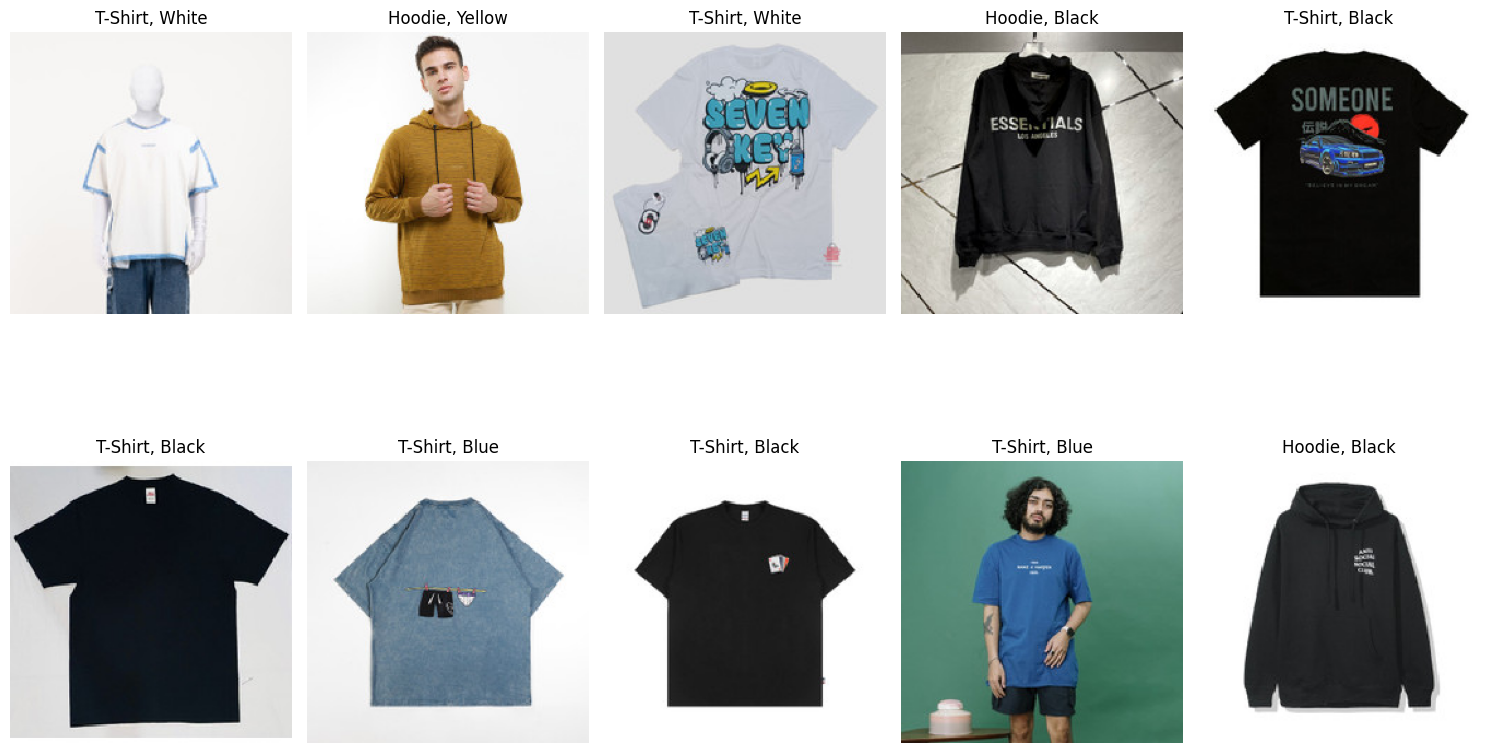

In [43]:
# Function to load and preprocess a single image (resize based on your model's input shape)
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)  # Resize the image to match your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Load all image paths from the test directory
image_files = [os.path.join(test_path, fname) for fname in os.listdir(test_path) if fname.endswith(('.jpg', '.png'))]

# Prepare to plot the images and predictions
plt.figure(figsize=(15, 10))

model.load_weights(checkpoint_path_color)
model_type.load_weights(checkpoint_path_type)
# Loop through each image, preprocess it, and make predictions
for i, img_path in enumerate(image_files):
    preprocessed_img = preprocess_image(img_path, target_size=(224, 224))  # Update target_size with your model's input dimensions
    pred_type = model_type.predict(preprocessed_img, verbose=0)  # Set verbose to 0
    pred_color = model.predict(preprocessed_img, verbose=0)  # Set verbose to 0
    
    # Convert predictions to class labels
    type_label = "Hoodie" if pred_type > 0.5 else "T-Shirt"
    color_label = ["Red", "Yellow", "Blue", "Black", "White"][np.argmax(pred_color)]

    # Plot the image
    plt.subplot(2, 5, i + 1)  # Adjust subplot grid size as needed
    img = image.load_img(img_path, target_size=(224, 224))  # Load original image
    plt.imshow(img)
    plt.title(f"{type_label}, {color_label}")  # Use the predictions as the title
    plt.axis('off')

    # Stop plotting after 9 images
    if i >= 9:  # Change this number to plot more or fewer images
        break

plt.tight_layout()
plt.show()

## Memuat, Memproses Gambar, dan Membuat Prediksi
Pada bagian ini, kami akan memuat gambar dari direktori test, memproses gambar tersebut agar sesuai dengan input model, dan kemudian membuat prediksi menggunakan model CNN yang telah dilatih untuk mengklasifikasikan tipe dan warna.

* Fungsi preprocess_image: Melakukan preprocessing image seperti sebelumnya


## Memuat Gambar dan Membuat Prediksi:
Kami akan memuat semua gambar dari direktori pengujian, memproses gambar-gambar tersebut, dan menggunakan model untuk membuat prediksi. Berikut adalah langkah-langkahnya:

* Mendapatkan Daftar Gambar: Mengambil semua file gambar dari direktori pengujian yang memiliki ekstensi .jpg atau .png. 
* Mempersiapkan List untuk Menyimpan Prediksi: Membuat dua list, type_predictions dan color_predictions, untuk menyimpan hasil prediksi tipe dan warna masing-masing gambar.
* Membuat Prediksi: Mengiterasi setiap gambar, memprosesnya, dan membuat prediksi untuk tipe dan warna menggunakan model yang telah dilatih.

In [41]:
# Function to load and preprocess a single image (resize based on your model's input shape)
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)  # resize the image to match your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    img_array = img_array / 255.0  # normalize the image (if necessary, based on your training)
    return img_array

# Load all image paths from the test directory
image_files = [os.path.join(test_path, fname) for fname in os.listdir(test_path) if fname.endswith(('.jpg', '.png'))]

# List to hold predictions
type_predictions = []
color_predictions = []


# Loop through each image, preprocess it, and make predictions
for img_path in image_files:
    preprocessed_img = preprocess_image(img_path, target_size=(224, 224))  # Update target_size with your model's input dimensions
    pred = model_type.predict(preprocessed_img, verbose = 0)  # Get predictions from the model
    type_predictions.append(pred)  # Store the prediction
    pred = model.predict(preprocessed_img, verbose = 0)  # Get predictions from the model
    color_predictions.append(pred)  # Store the prediction

# Step 5: Membuat DataFrame untuk Submission
Setelah mendapatkan prediksi dari model untuk tipe dan warna, langkah selanjutnya adalah menyusun hasil tersebut dalam bentuk DataFrame yang dapat digunakan untuk pengiriman (submission). Berikut adalah langkah-langkah yang diambil untuk membuat file submission:

## Langkah 1: Mengonversi Prediksi ke Kelas
Kita akan mengonversi hasil prediksi untuk tipe dan warna menjadi kelas yang sesuai:

* Mengonversi Tipe: Jika prediksi untuk "Hoodie" lebih besar dari 0.5, maka kita anggap sebagai kelas 1; jika tidak, kelas 0 untuk "T-Shirt".
* Mengonversi Warna:Menggunakan np.argmax untuk mendapatkan kelas dengan probabilitas tertinggi dari prediksi warna.

## Langkah 2: Membuat DataFrame Submission
Kami akan membuat DataFrame yang berisi ID gambar, tipe, dan warna. ID gambar diambil dari nama file gambar tanpa ekstensi.
## Langkah 3: Mengurutkan DataFrame
DataFrame diurutkan berdasarkan ID untuk memastikan konsistensi dan kemudahan pemeriksaan.
## Langkah 4: Validasi Jumlah Prediksi
Memastikan bahwa jumlah ID gambar cocok dengan jumlah prediksi yang telah dibuat.
## Langkah 5: Menyimpan DataFrame sebagai CSV
Akhirnya, kami menyimpan DataFrame sebagai file CSV untuk submission.

In [21]:
# Assume type_predictions and color_predictions are defined and contain the model predictions
types = [1 if pred > 0.5 else 0 for pred in type_predictions]  # pred[1] represents the probability for "Hoodie"  # Get the predicted class for 'type'
colors = [np.argmax(pred) for pred in color_predictions]  # Get the predicted class for 'color'

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': [os.path.splitext(fname)[0] for fname in os.listdir(test_path)],  # Get the image IDs without extensions
    'jenis': types,
    'warna': colors
})

# Sort the DataFrame by 'id'
submission_df.sort_values(by='id', inplace=True)

# Make sure the length of submission_df matches the number of predictions
if len(submission_df) != len(type_predictions):
    print("Warning: Number of image IDs does not match the number of predictions.")

# Save the DataFrame as a CSV file for submission
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
